## LFW - Numpy

First we obtain the packages and data we will need.

In [1]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

In [2]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

Let's have a closer look at our data.

In [4]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


We see that the dataset describes 7 people, for each of whom there are 1288/7 = 184 photos each with 1850 pixels. Next we create a train/test split, normalise the data relative to the train set and train a PCA classifier.

In [16]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

# Center data
mean = np.mean(X_train, axis=0)
X_train -= mean
X_test -= mean
#Eigen-decomposition
U, S, V = np.linalg.svd(X_train, full_matrices=False)
components = V[:n_components]
eigenfaces = components.reshape((n_components, h, w))
#project into PCA subspace
X_transformed = np.dot(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = np.dot(X_test, components.T)
print(X_test_transformed.shape)

(966, 150)
(322, 150)


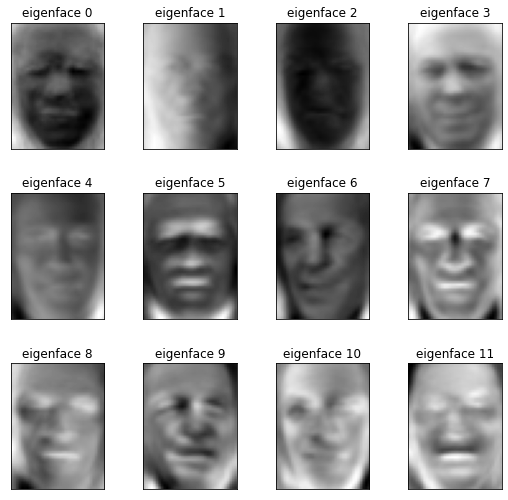

In [12]:
import matplotlib.pyplot as plt
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

(966,)


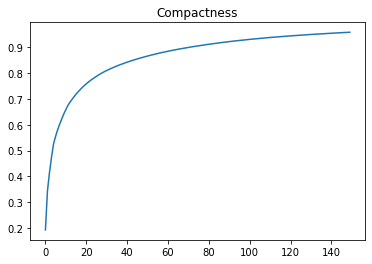

In [13]:
explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = np.cumsum(explained_variance_ratio)
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components)

plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [18]:
#build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]
predictions = estimator.predict(X_test_transformed)
correct = predictions==y_test
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
4
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:",correct)
print("Total Correct:",np.sum(correct))
print("Accuracy:",np.sum(correct)/total_test)

Total Testing 322
Predictions [3 3 1 3 4 3 3 1 3 3 3 6 3 3 3 3 4 3 3 4 1 1 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3
 3 3 1 3 1 3 1 1 3 3 3 4 3 3 3 3 3 3 2 1 3 5 3 1 1 3 6 2 4 1 4 3 3 4 6 3 3
 3 2 3 6 1 3 6 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 3 1 3 3 3 3 3 3 3 3 3 3 3 1 3
 1 6 3 3 3 1 4 1 3 1 3 3 1 3 4 4 3 1 3 6 6 6 3 3 4 3 3 6 3 1 3 3 1 3 5 1 3
 6 1 1 3 3 3 3 3 6 3 3 3 6 4 5 1 3 3 5 1 3 3 1 3 3 1 6 3 3 3 2 3 3 3 3 3 3
 3 3 3 3 2 4 3 2 3 4 3 3 3 3 5 3 3 3 3 3 1 4 2 4 3 6 5 3 3 3 5 3 2 3 3 3 3
 3 3 1 3 3 3 1 3 3 3 3 0 3 1 3 3 3 3 3 4 2 3 3 3 3 3 1 4 4 4 3 4 3 4 3 1 3
 3 3 3 3 1 3 5 1 1 3 1 1 3 3 3 3 3 3 3 3 3 1 1 3 3 3 3 3 3 3 4 3 3 5 3 3 3
 3 3 3 3 3 6 3 3 1 3 3 3 1 3 3 3 1 3 3 3 4 1 3 3 3 3]
Which Correct: [ True  True False  True False  True False  True  True  True  True False
  True False  True  True False  True  True  True  True False  True False
 False False False  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False  True
 False  T

In [19]:
 print(classification_report(y_test, predictions, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.08      0.14        13
     Colin Powell       0.69      0.57      0.62        60
  Donald Rumsfeld       0.67      0.22      0.33        27
    George W Bush       0.62      0.90      0.73       146
Gerhard Schroeder       0.40      0.40      0.40        25
      Hugo Chavez       0.67      0.40      0.50        15
       Tony Blair       0.56      0.25      0.35        36

         accuracy                           0.61       322
        macro avg       0.66      0.40      0.44       322
     weighted avg       0.63      0.61      0.57       322

